In [2]:
# hide pakcage non critical warnings

import warnings

warnings.filterwarnings('ignore')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))


%load_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
import matplotlib.pyplot as plt

import scipy.io as sio

import torch
import torch.nn as nn

import torch.nn.functional as F
import torch.nn.init as init

from custom_data import DCCPT_data

from config import cfg, get_data_dir, get_output_dir, AverageMeter, remove_files_in_dir

from tensorboard_logger import Logger

import os
import random
import pickle
import numpy as np

import data_params as dp

In [4]:
import devkit.api as dk

In [5]:
datadir = get_data_dir("mnist")
outputdir = get_output_dir("mnist")

In [6]:
datadir

'/Users/jasper/dev/DCC/data/mnist'

In [7]:
datadir

'/Users/jasper/dev/DCC/data/mnist'

In [96]:
with open(os.path.join(datadir, "pretrained.pkl"), 'rb') as f:
    pretrain_info = pickle.load(f)

In [97]:
pretrain_info.keys()

dict_keys(['labels', 'Z', 'data'])

In [99]:
print(pretrain_info['data'].shape, pretrain_info['Z'].shape, pretrain_info['labels'].shape)

(70000, 784) (70000, 10) (70000,)


In [101]:
y_gt_pretrain = pretrain_info['labels']
y_gt_pretrain.shape

(70000,)

In [104]:
X = pretrain_info['data']
X.shape

(70000, 784)

In [105]:
Z = pretrain_info['Z']
Z.shape

(70000, 10)

In [106]:
ixs_selected = np.random.choice(len(Z),10000, replace=False)

# viz raw data [X]

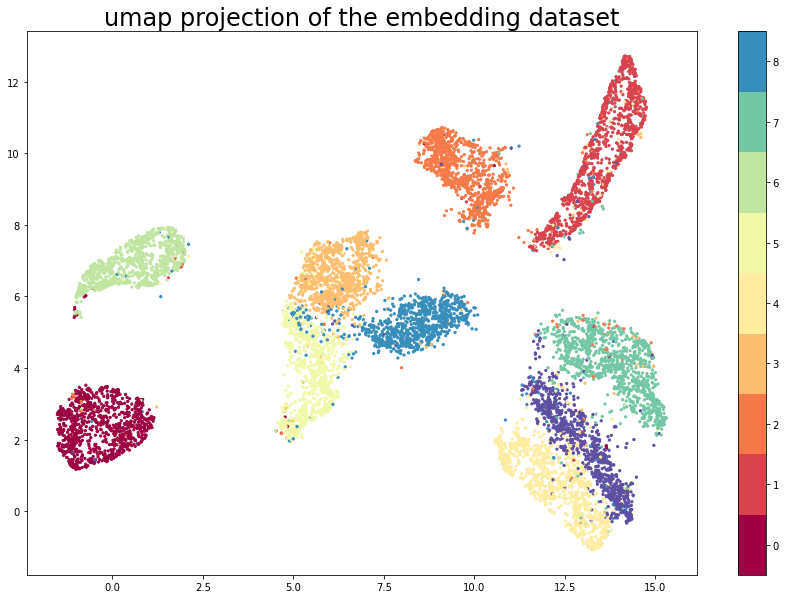

In [107]:
dk.data_viz(X[ixs_selected], y_gt_pretrain[ixs_selected])

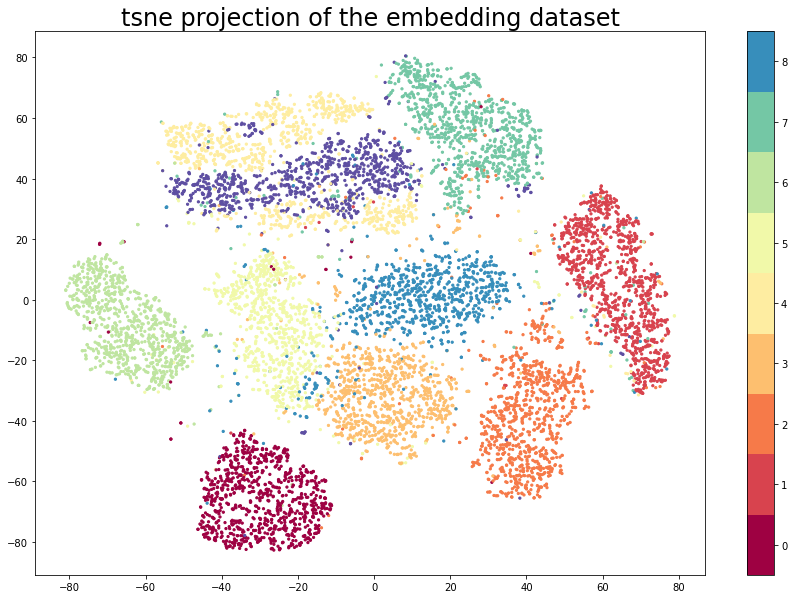

In [108]:
dk.data_viz(X[ixs_selected], y_gt_pretrain[ixs_selected], method='tsne')

# viz embedding of sdae [Z]

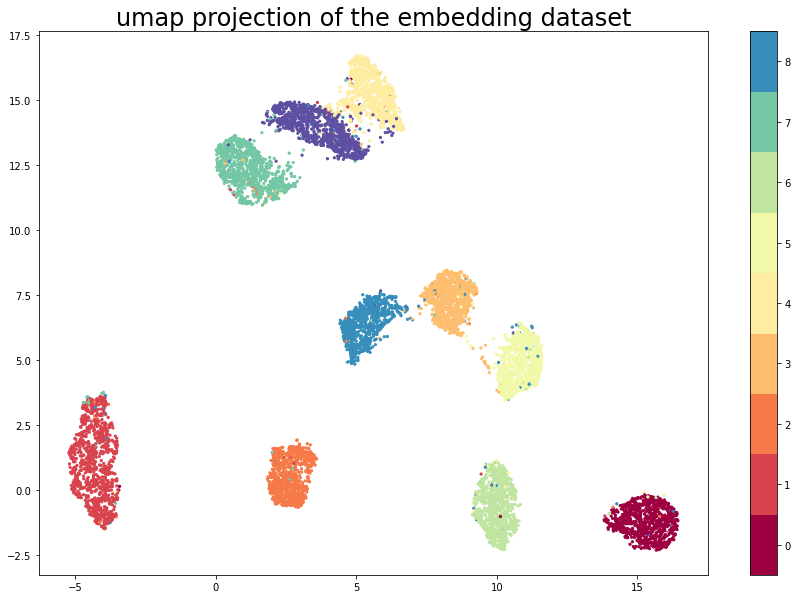

In [93]:
dk.data_viz(Z[ixs_selected], y_gt_pretrain[ixs_selected])

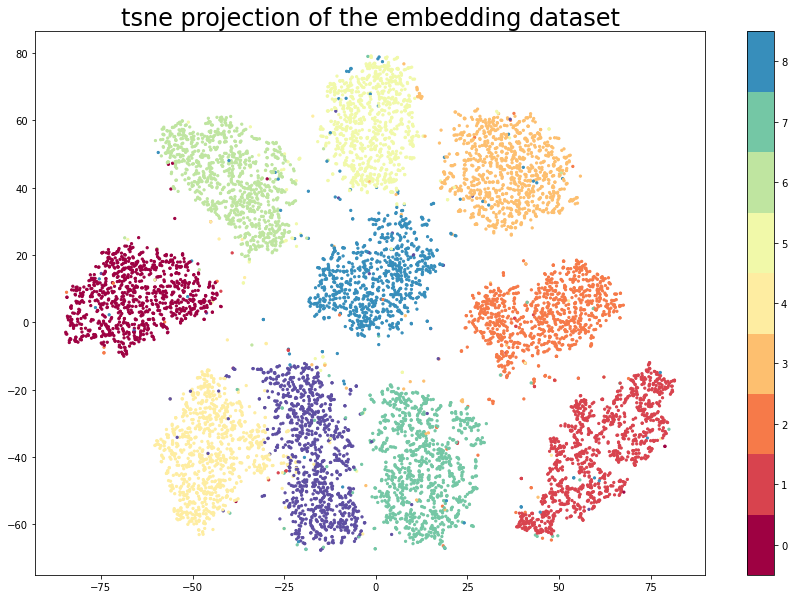

In [94]:
dk.data_viz(Z[ixs_selected], y_gt_pretrain[ixs_selected], method='tsne')

# viz embedding of dcc [U]

## calculate U from checkpoint

In [109]:
from DCCLoss import DCCWeightedELoss, DCCLoss

In [110]:
datadir

'/Users/jasper/dev/DCC/data/mnist'

In [129]:
dcc_ckp = torch.load(os.path.join(datadir, "results/FTcheckpoint_100.pth.tar"))

In [130]:
dcc_ckp.keys()

dict_keys(['epoch', 'state_dict', 'criterion_state_dict', 'optimizer', 'sigma1', 'sigma2', 'lambda', 'delta', 'delta1', 'delta2'])

In [131]:
Z.shape

(70000, 10)

In [132]:
criterion2 = DCCLoss(Z.shape[0], Z.shape[1], Z, size_average=True)

In [133]:
criterion2.load_state_dict(dcc_ckp['criterion_state_dict'])

<All keys matched successfully>

In [134]:
U = criterion2.U.data.cpu().numpy()

In [136]:
U.shape[-1]

10

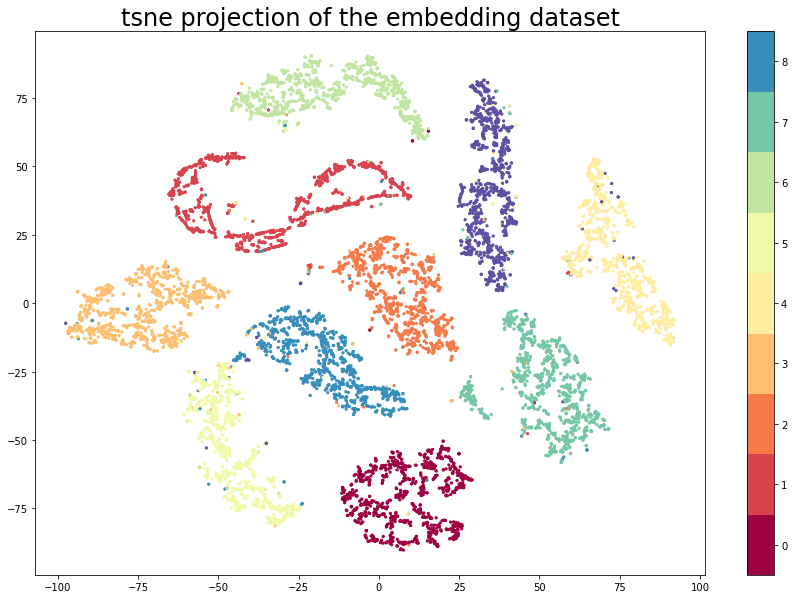

In [135]:
dk.data_viz(X=U[ixs_selected], y=y_gt[ixs_selected], method='tsne')

## get the U from final output

In [117]:
dcc_res = sio.loadmat(os.path.join(datadir, "results/features.mat"))

In [118]:
dcc_res.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Z', 'U', 'gtlabels', 'w', 'cluster'])

In [119]:
U_final = dcc_res['U']

In [120]:
y_gt = dcc_res['gtlabels'].flatten()

In [144]:
y_pred = dcc_res['cluster'].flatten()

In [145]:
y_pred.shape

(70000,)

In [124]:
assert (y_gt == y_gt_pretrain).all()

In [126]:
print(U_final.shape, y_gt.shape)

(70000, 10) (70000,)


## viz U

### umap

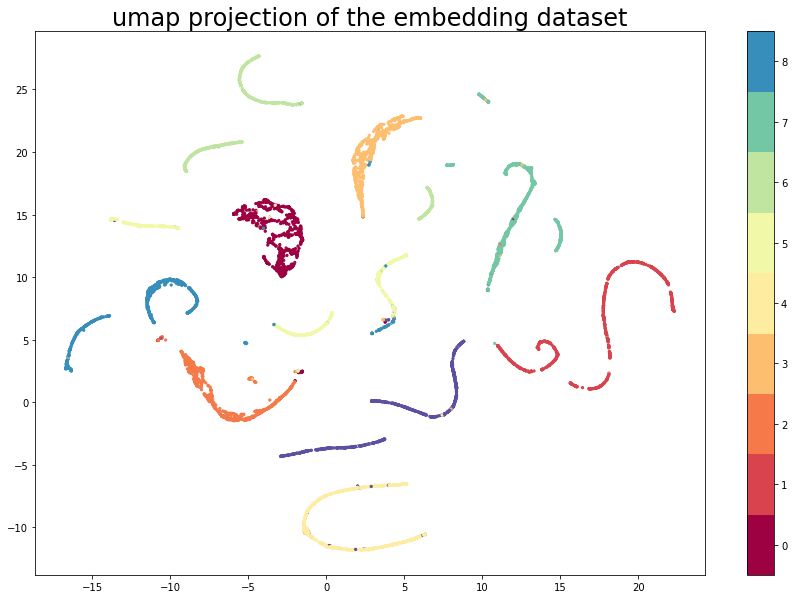

In [127]:
dk.data_viz(X=U_final[ixs_selected], y=y_gt[ixs_selected], method='umap')

### tsne

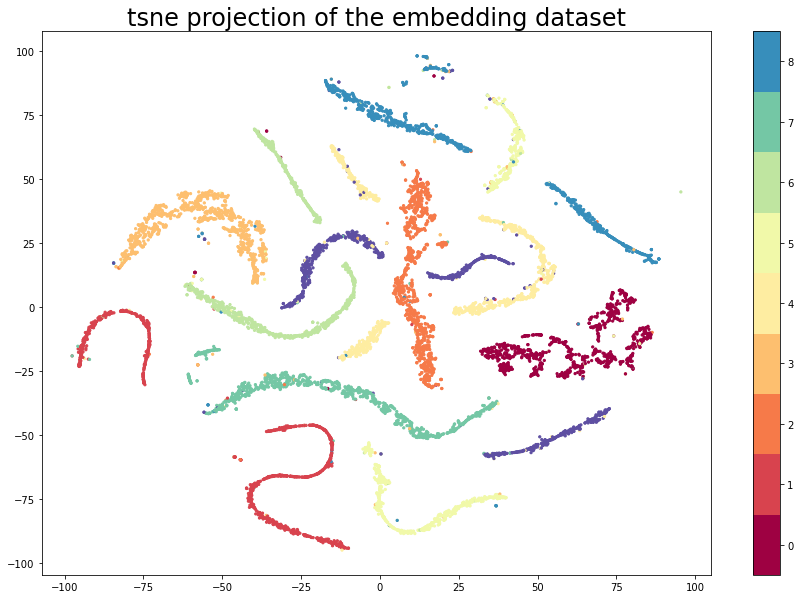

In [128]:
dk.data_viz(X=U_final[ixs_selected], y=y_gt[ixs_selected], method='tsne')

# viz images by cluster

In [161]:
def mgcMultiHeat_mse2(**kwargs):
    
    """
    return multiple heatmap plot
    """
    from mpl_toolkits.axes_grid1 import ImageGrid
    import math
    
    def_vals = {'x_train': None,
                'arr_mse': None,
                'arr_mse_indx': None, 
                'cell_id': None,
                'label_class': 'class name',
                'set_random': False,
                'rowx' : 7, 
                'colx' :5, 
                'img_rows' : 25, 
                'img_cols': 24, 
                'fname': 'plt_heat'}

    for k, v in def_vals.items():
        kwargs.setdefault(k, v)

    x_train = kwargs['x_train']
    arr_mse = kwargs['arr_mse']
    arr_mse_indx = kwargs['arr_mse_indx']
    cell_id = kwargs['cell_id']
    label_class = kwargs['label_class']
    set_random = kwargs['set_random']
    rowx = kwargs['rowx']
    colx = kwargs['colx']
    img_rows = kwargs['img_rows']
    img_cols = kwargs['img_cols']
    fname = kwargs['fname']
    
    import time
    timestr = time.strftime("%Y%m%d-%H%M%S")
    _fname_ext = fname + "_" + timestr

    if arr_mse_indx is None:
        arr_mse_indx = np.array(range(x_train.shape[0]))
        
    if arr_mse is None:
        arr_mse = np.empty((x_train.shape[0]))
        arr_mse.fill(np.nan)
        total_cell = x_train.shape[0]
        print(arr_mse)
        print(type(arr_mse))
    else:
        total_cell = len(arr_mse_indx)
        #arr_mse = -np.sort(arr_mse)
        #arr_mse = arr_mse[np.argsort(-arr_mse)]
        
    if (len(arr_mse_indx) <= rowx * colx):
        rowx = math.ceil(len(arr_mse_indx) / colx)
        row_idx = arr_mse_indx[:]
        
    else:
        rowx = rowx
        
        if set_random == True:
            row_idx = np.random.choice(arr_mse_indx, rowx * colx)
            print("select random")
        else:
            row_idx = arr_mse_indx[:rowx * colx]

    if cell_id is None:
        cell_id = np.array(['c_' + str(i).zfill(4) for i in range(x_train.shape[0])])
        
        
    #row_idx = arr_mse_indx
    #print("row_idx", row_idx)
    x_train_sub = x_train[row_idx,:]
    arr_mse_sub = arr_mse[row_idx]
    #print("before sorted", arr_mse_sub)
    
    arr_label_sub = range(len(row_idx))
    cell_id_sub = cell_id[row_idx]
    #cell_id =  range(len(row_idx))

    # sort by mse descending
    
    mse_idx = np.argsort(arr_mse_sub)[::-1]
    #print("mse_idx", mse_idx)
    #x_train_sub = x_train_sub1[mse_idx]
    #arr_mse_sub_sort = arr_mse_sub[mse_idx]
    #print("sorted", arr_mse_sub)
    #row_idx_sub = row_idx[mse_idx]
    #cell_id = row_idx

    print('total cell: {0}/{1} cells'.format(len(arr_mse_sub), total_cell))
    print("unique cell {0}/{1}".format(pd.Series(cell_id[arr_mse_indx]).nunique(), total_cell))
    #print("class: {0}".format(label_class))

    indx = range(x_train_sub.shape[0])
    fig = plt.figure(figsize=(20, 10))
    
    grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                     nrows_ncols=(rowx, colx),
                     axes_pad=0.45,
                     share_all=True,
                     cbar_location="right",
                     cbar_mode="single",
                     cbar_size="7%",
                     cbar_pad=0.15,
                     )

    # Add data to image grid
    #for arr_indx, ax in enumerate(grid):
    for arr_indx, ax in zip(mse_idx, grid):
        im = ax.imshow(x_train_sub[arr_indx,:,:], interpolation='spline16', cmap=plt.cm.get_cmap('RdYlGn_r'))
        im.set_clim(vmin=0, vmax=1) #max_value = -81.53, min_value = -182.00
        ax.set_title("MSE {0:.3g}, \n i:{1}, ci: {2}".format(arr_mse_sub[arr_indx], row_idx[arr_indx], cell_id_sub[arr_indx]), color='red')
        plt.tight_layout()
    
    # Colorbar
    ax.cax.colorbar(im)
    ax.cax.toggle_label(True)
    
    fig.suptitle("Class ID {0}".format(label_class), fontsize=20, fontweight=0, color='black', style='italic', y=1.02)

    plt.savefig("./{}.png".format(_fname_ext), bbox_inches = 'tight')
    #plt.savefig("./{}.svg".format(_fname_ext), bbox_inches = 'tight') 
    plt.show()  

In [163]:
plt.imshow??

In [153]:
import pandas as pd

In [149]:
lst_top_classes = pd.Series(y_pred).value_counts().index.tolist()[:10]
lst_bottom_classes = pd.Series(y_pred).value_counts().index.tolist()[-20:]

lst_ix_selected = [i for i,v in enumerate(y_pred) if v in lst_top_classes]

len(lst_ix_selected)

68691

In [157]:
28*28

784

In [158]:
X_2d = X.reshape(-1, 28, 28)

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
select random
total cell: 18/70000 cells
unique cell 9/70000


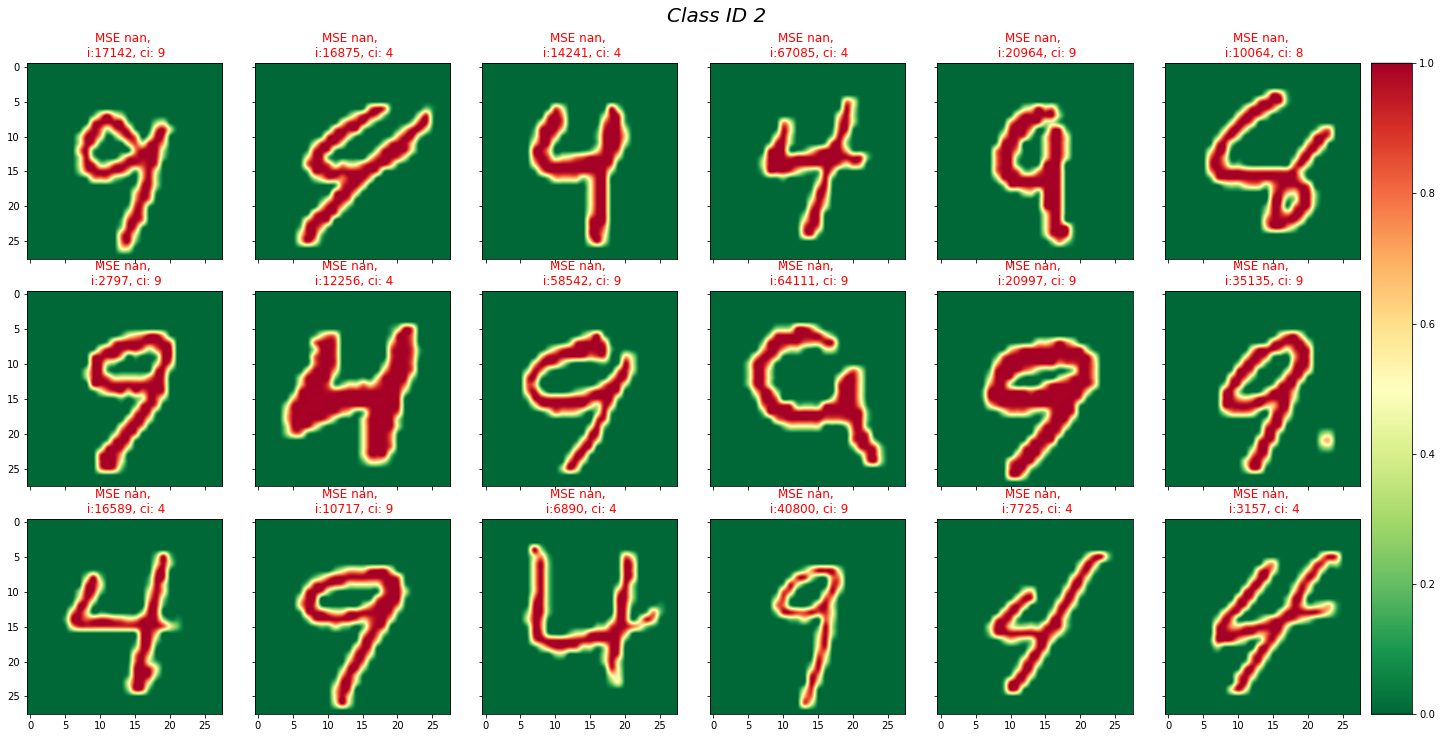

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
select random
total cell: 18/70000 cells
unique cell 9/70000


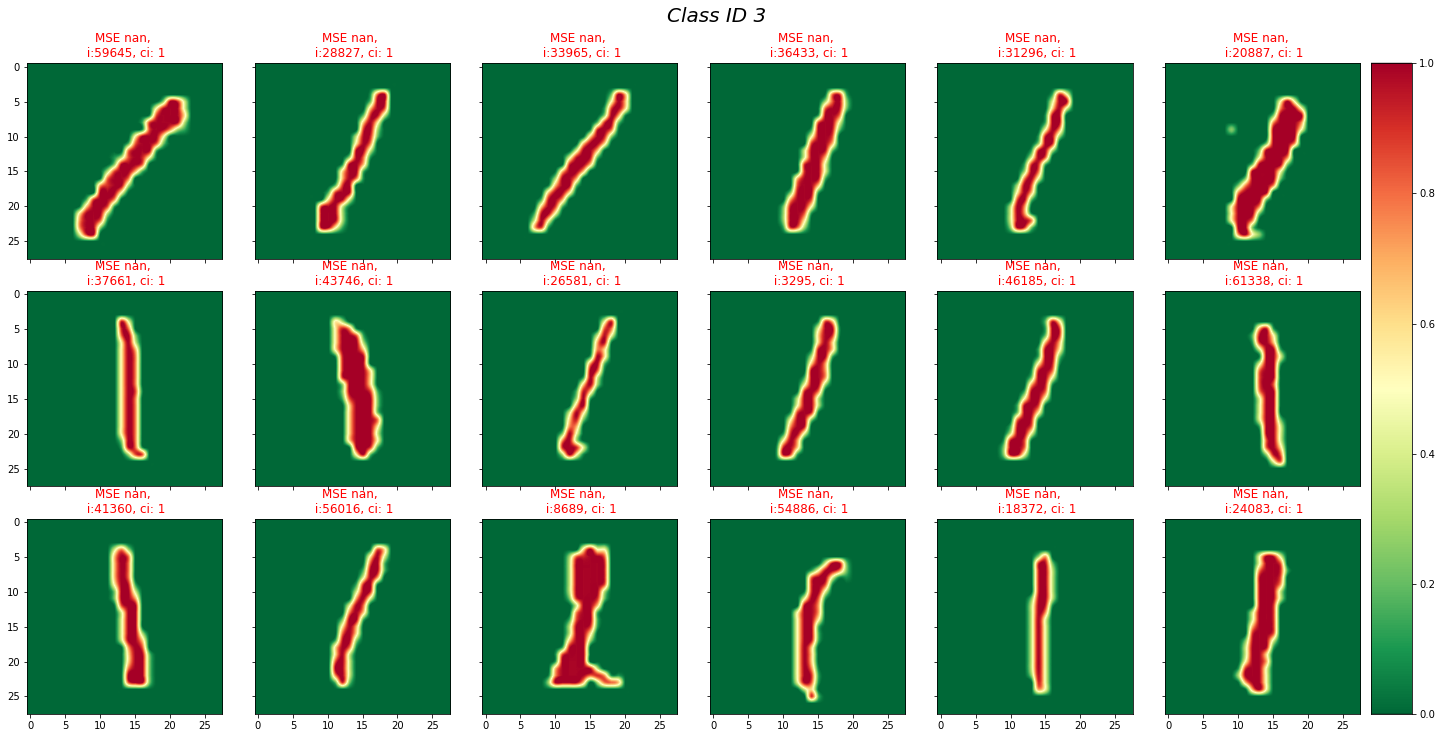

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
select random
total cell: 18/70000 cells
unique cell 9/70000


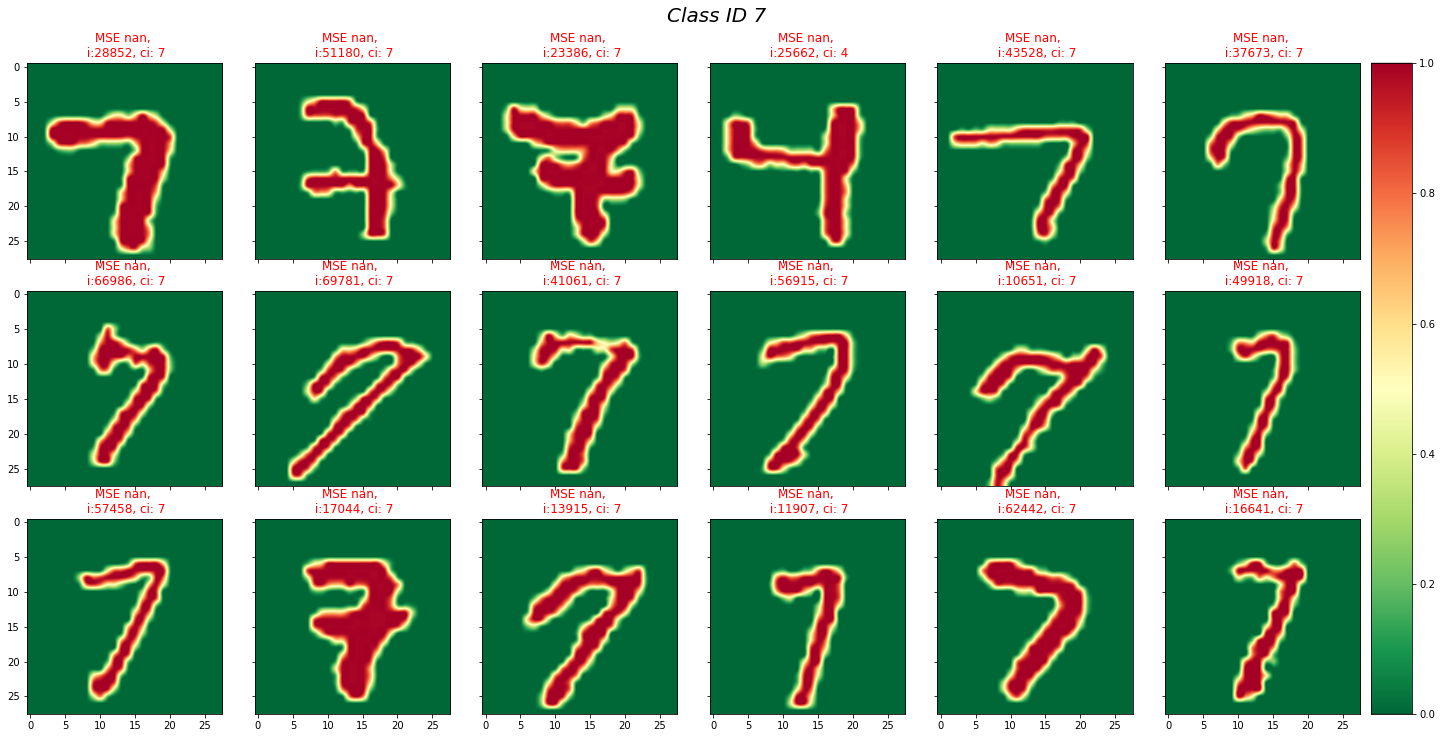

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
select random
total cell: 18/70000 cells
unique cell 9/70000


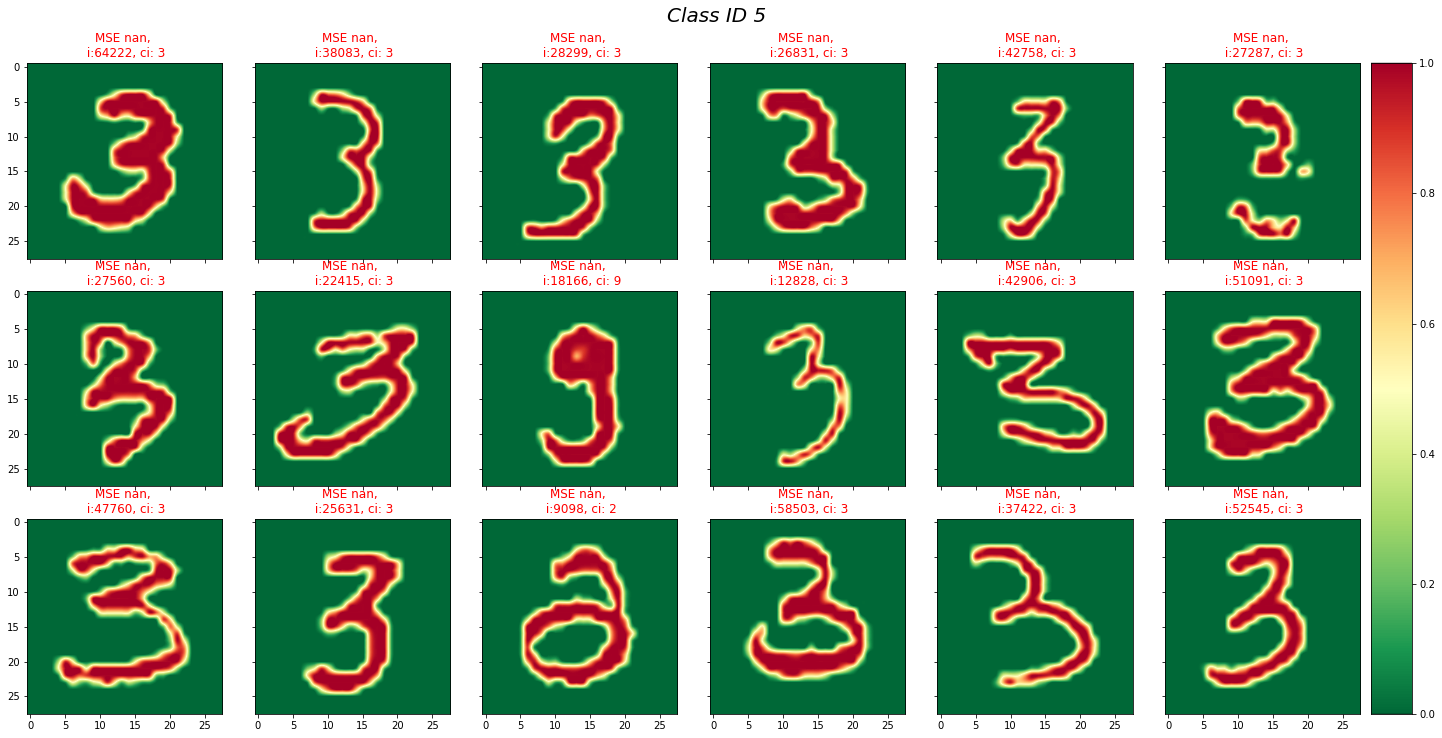

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
select random
total cell: 18/70000 cells
unique cell 10/70000


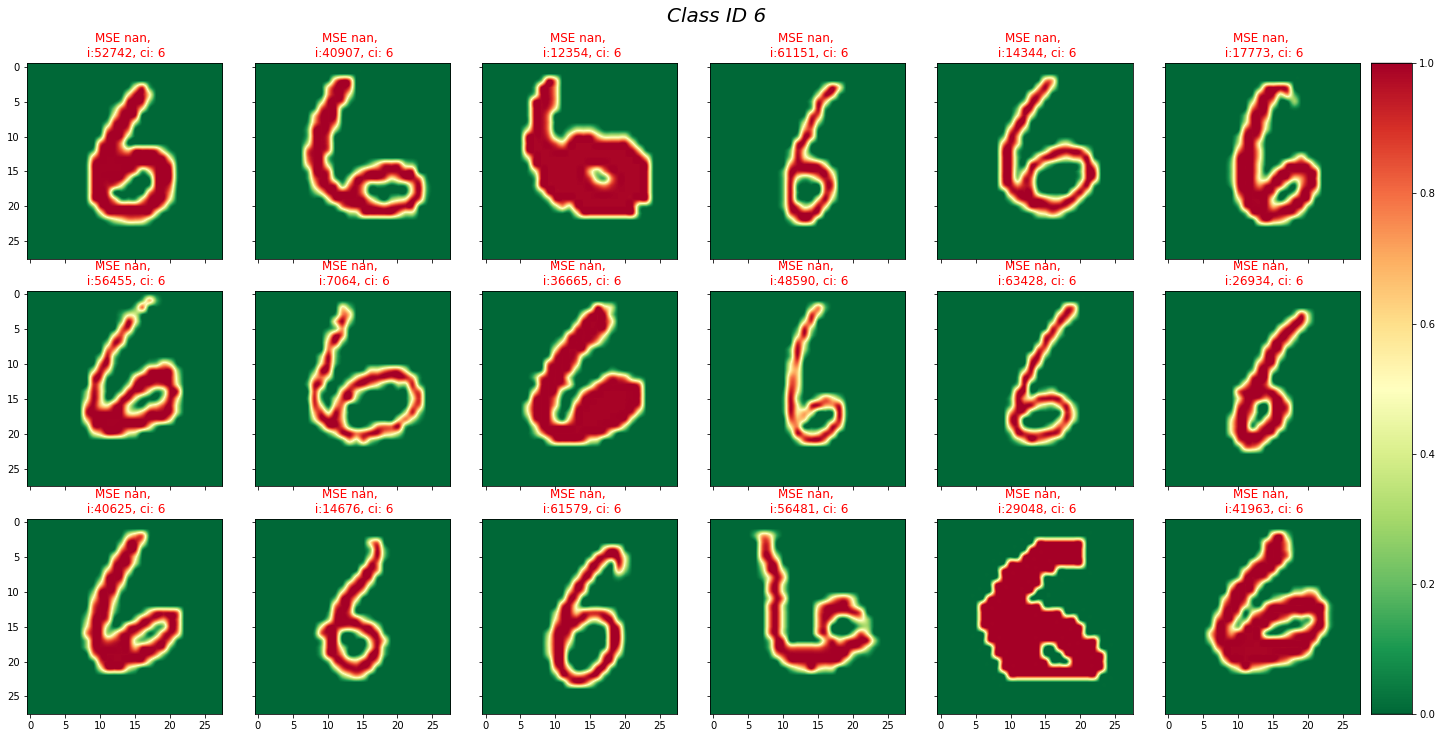

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
select random
total cell: 18/70000 cells
unique cell 10/70000


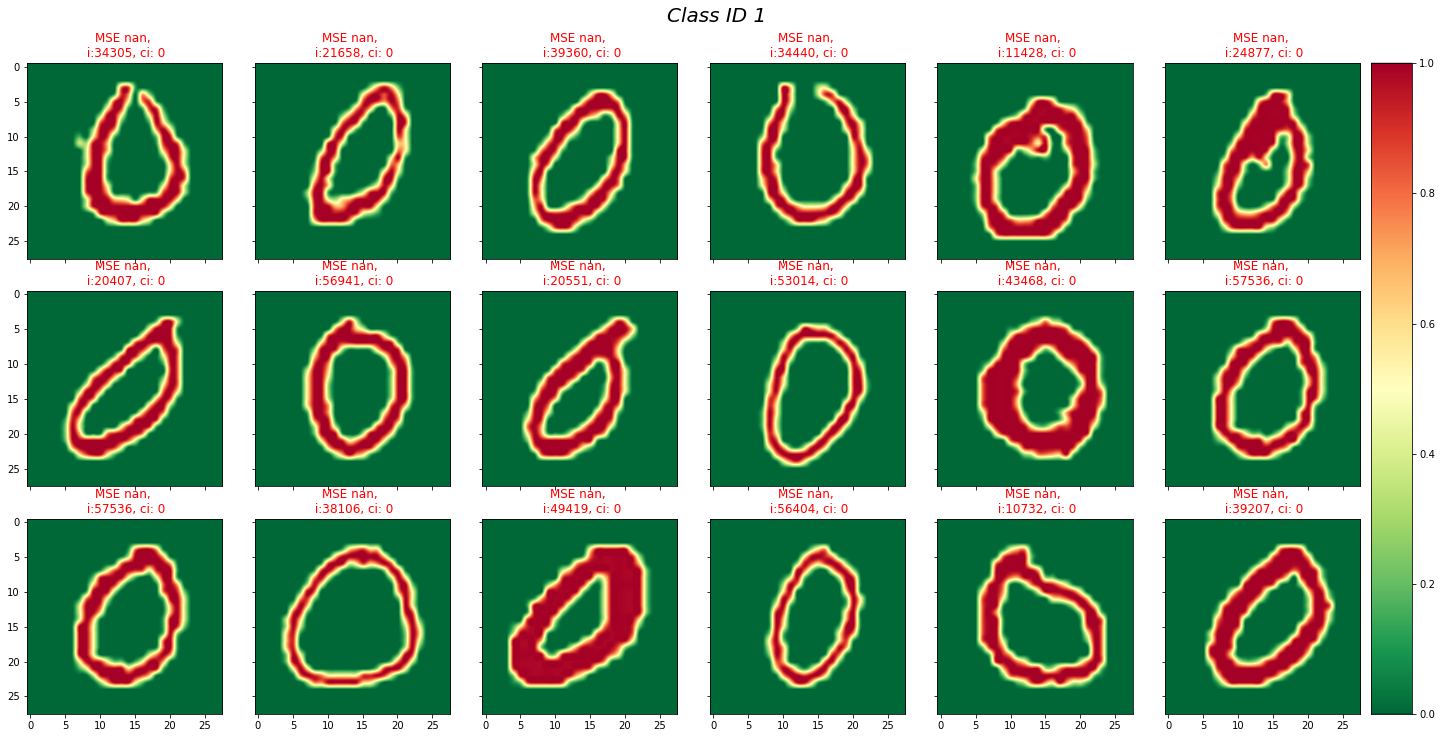

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
select random
total cell: 18/70000 cells
unique cell 9/70000


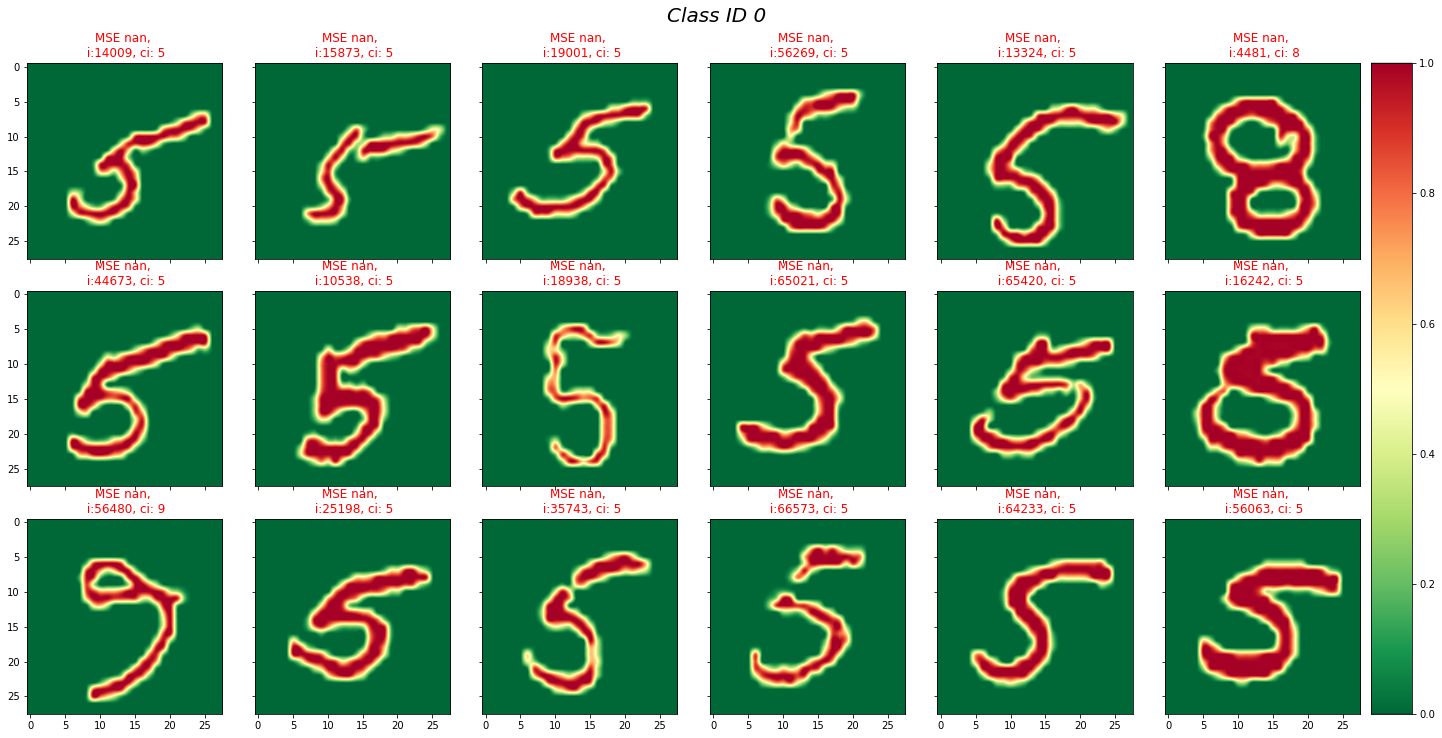

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
select random
total cell: 18/70000 cells
unique cell 10/70000


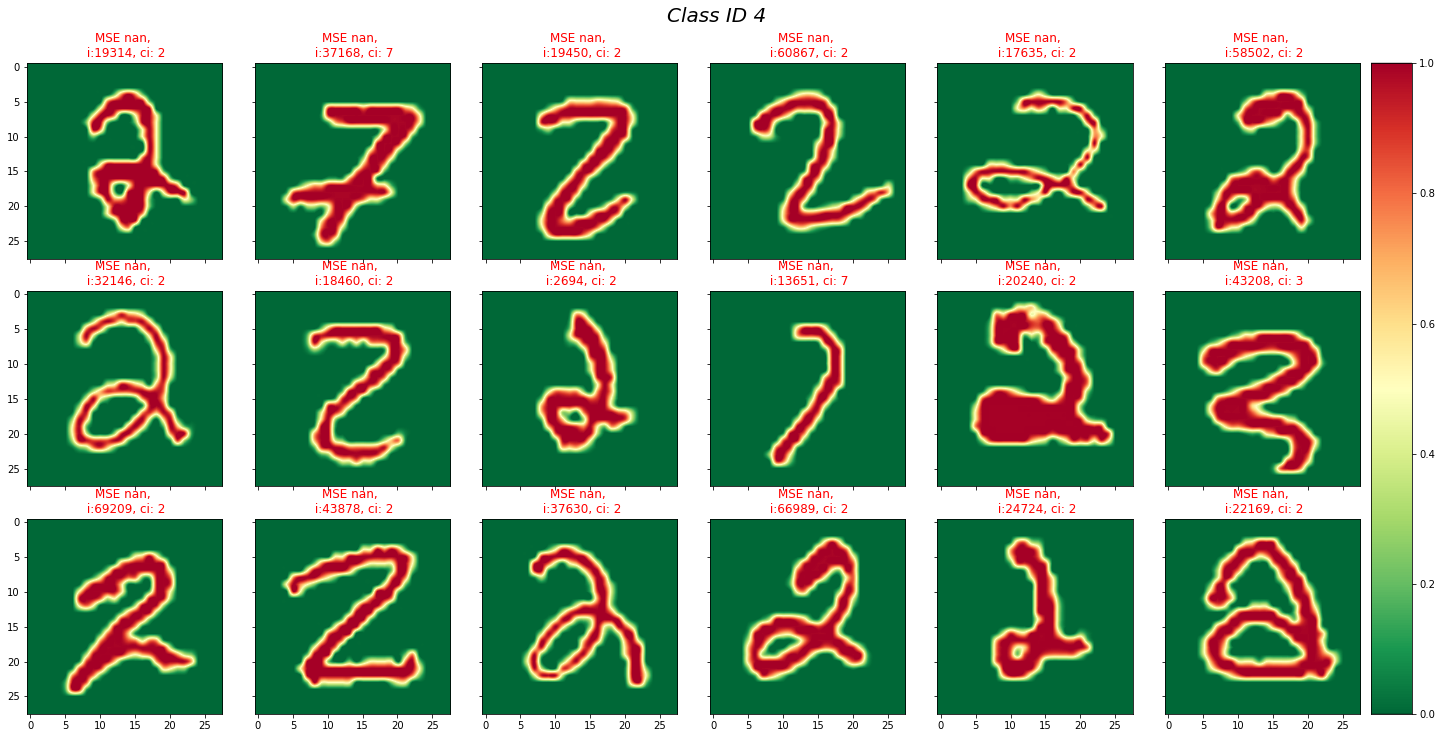

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
select random
total cell: 18/70000 cells
unique cell 10/70000


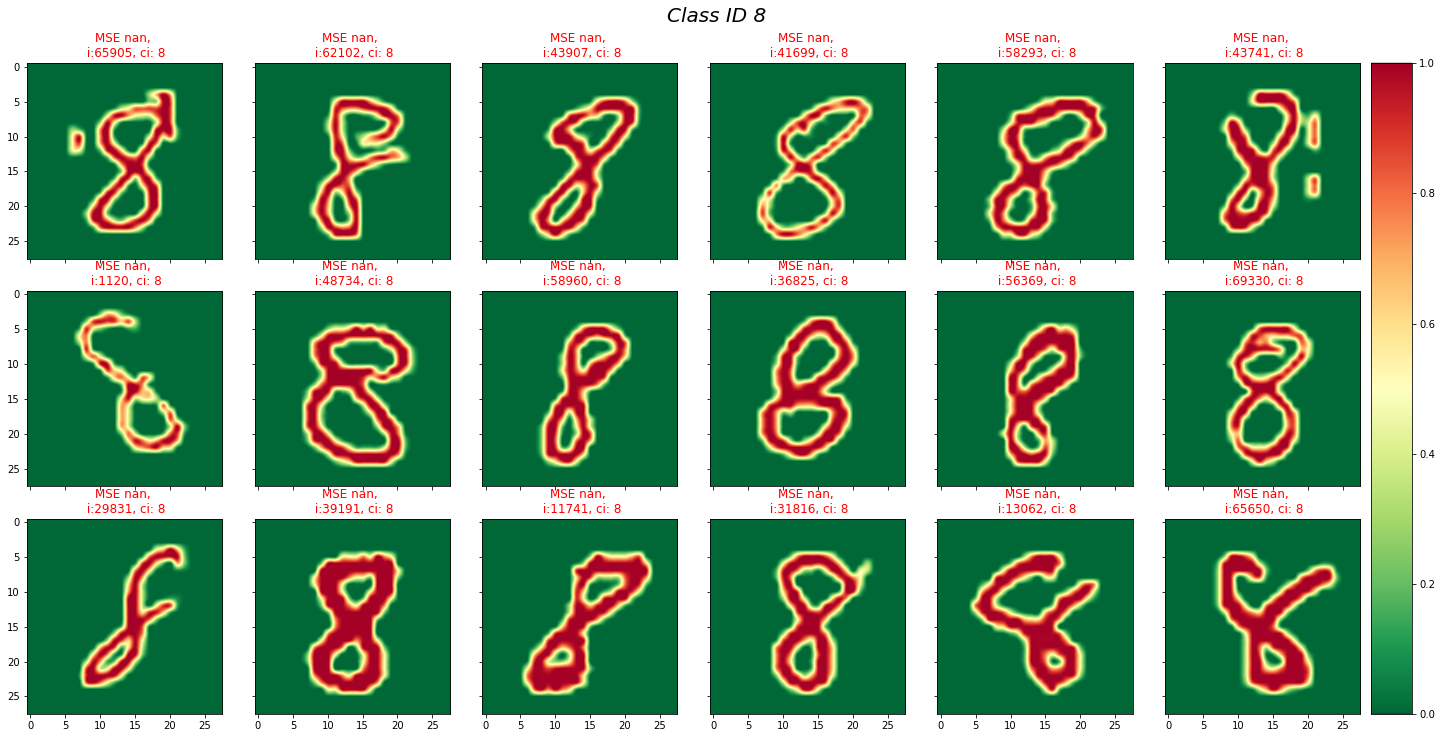

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
select random
total cell: 18/70000 cells
unique cell 4/70000


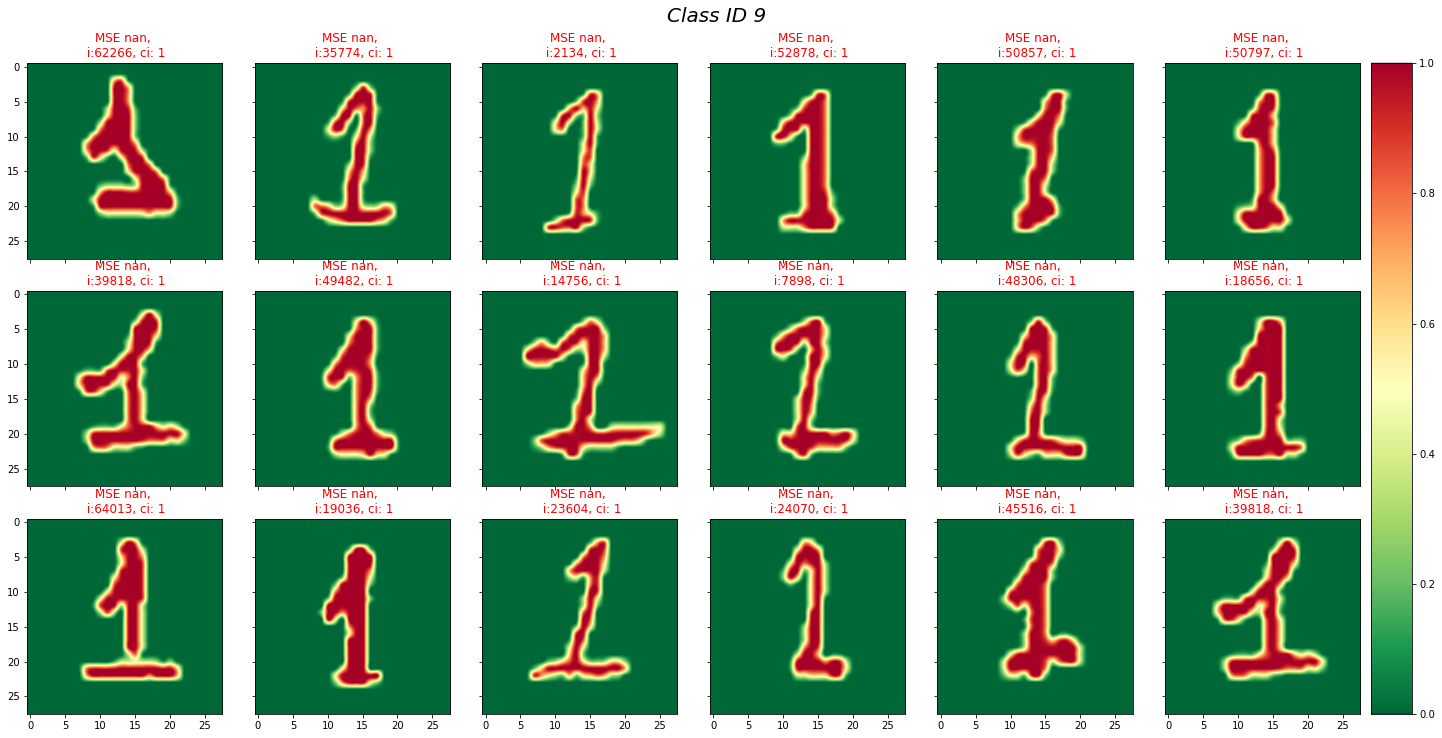

In [159]:
# default parameter values
def_vals = {'x_train' : X_2d, 
            'arr_mse': None, 
            'arr_mse_indx': None, 
            'cell_id': y_gt,
            'label_class': 'my_class', 
            'set_random': True,
            'rowx' : 3, 
            'colx' :6, 
            'img_rows' : 25, 
            'img_cols': 24, 
            'fname': 'plt_heat'}
# update dictionary key value

selcted_clusters = lst_top_classes
# selcted_clusters = np.unique(arr_label)
for cluster_id in selcted_clusters:
    class_indx = np.where(y_pred == cluster_id)[0]
    
    def_vals['label_class'] = cluster_id
    def_vals['arr_mse_indx'] = class_indx
    mgcMultiHeat_mse2(**def_vals)

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
total cell: 2/70000 cells
unique cell 2/70000


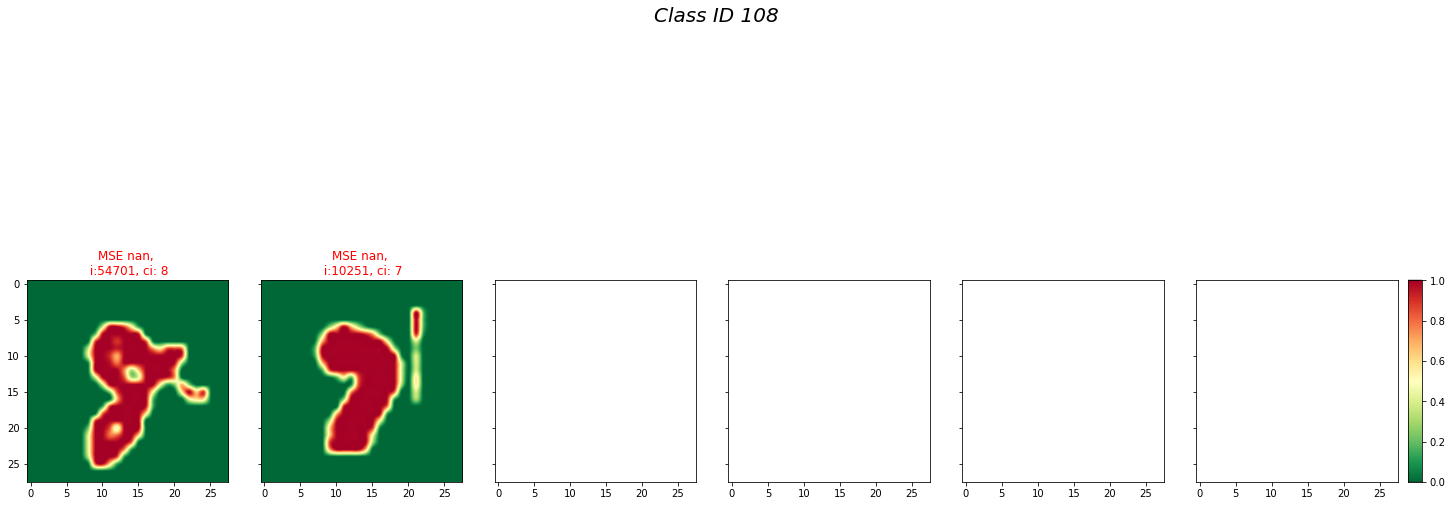

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
total cell: 2/70000 cells
unique cell 1/70000


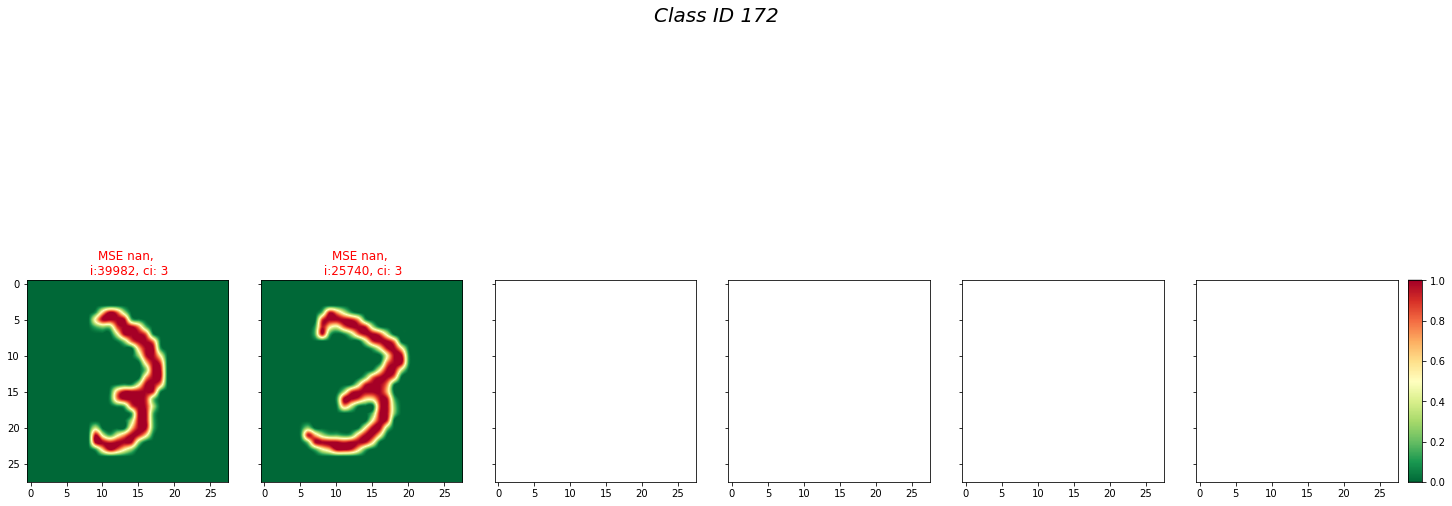

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
total cell: 2/70000 cells
unique cell 1/70000


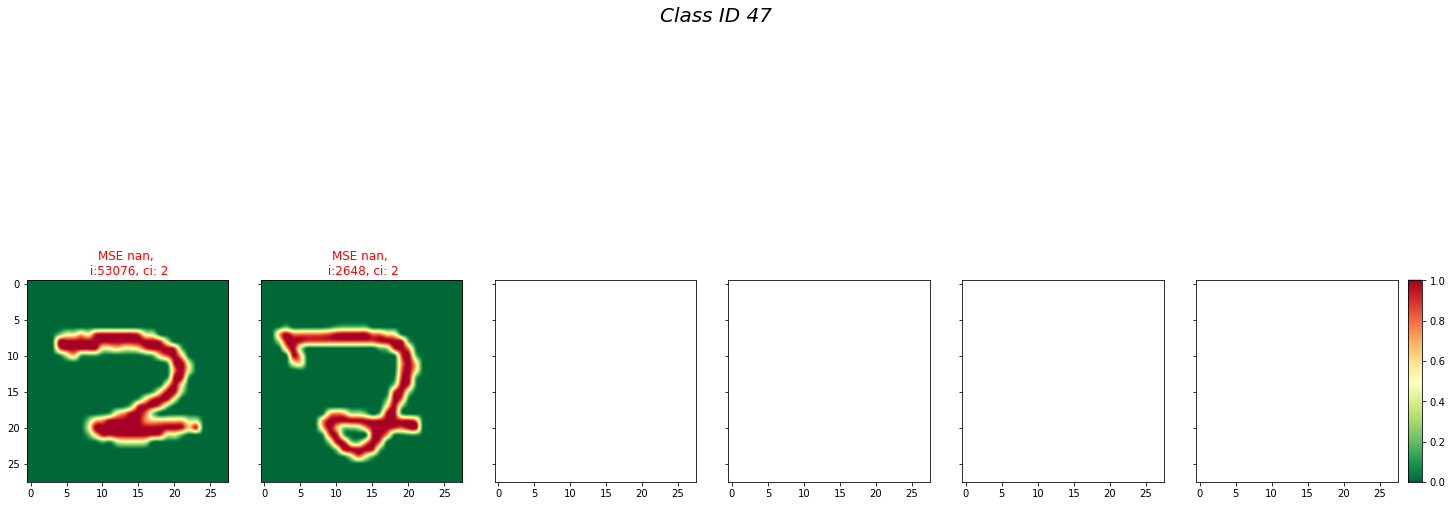

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
total cell: 2/70000 cells
unique cell 1/70000


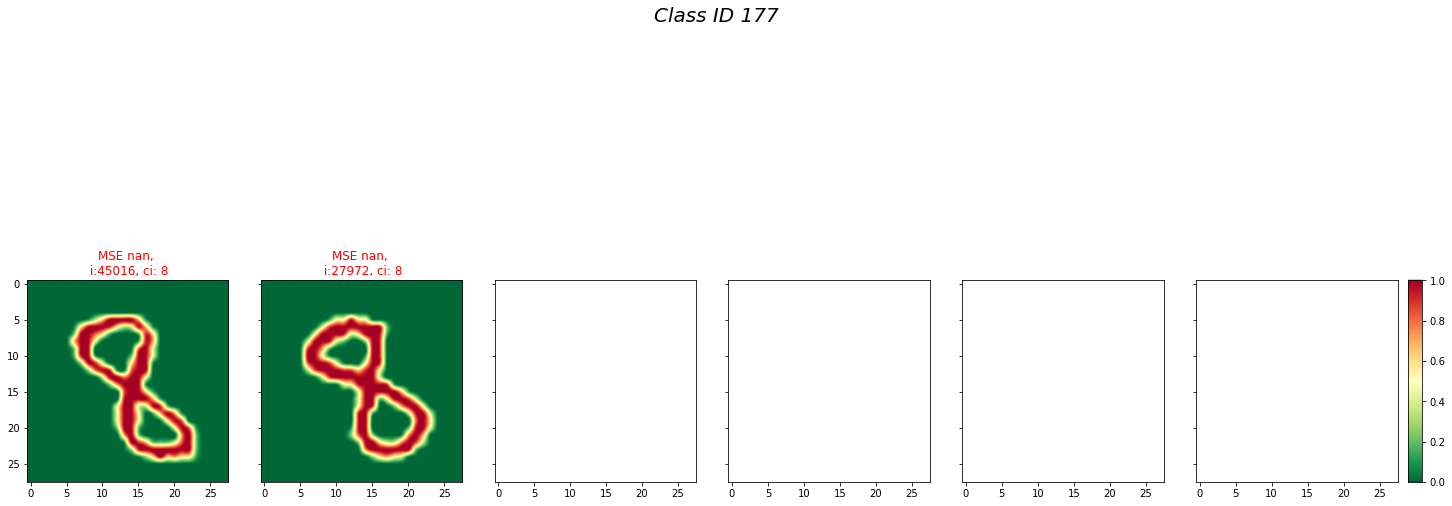

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
total cell: 2/70000 cells
unique cell 1/70000


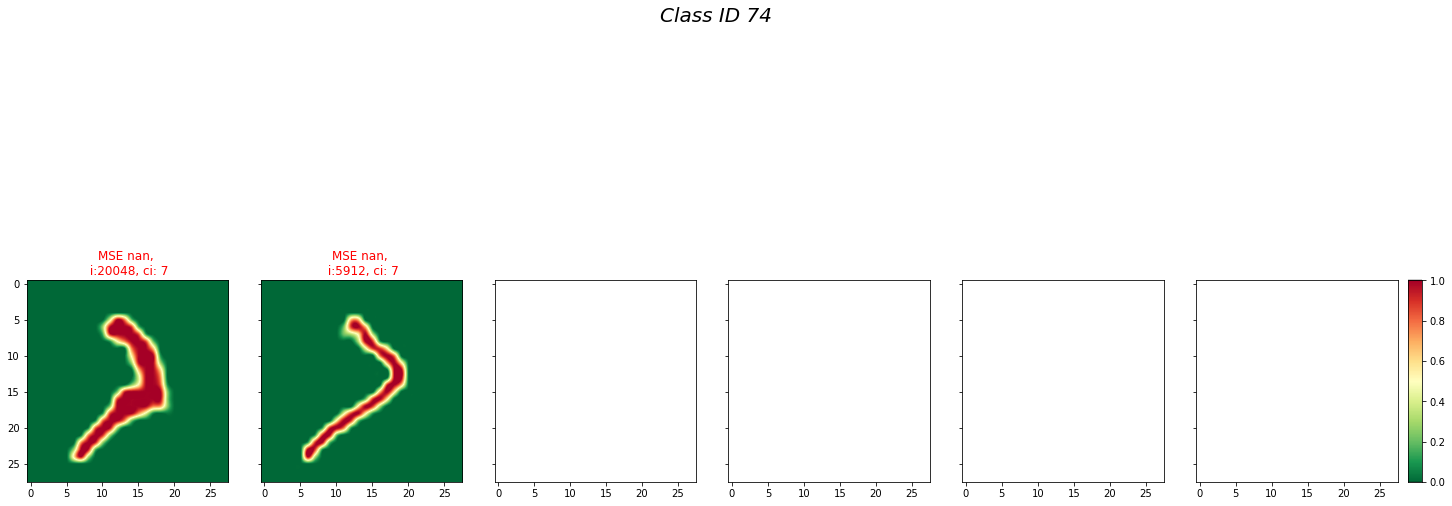

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
total cell: 2/70000 cells
unique cell 1/70000


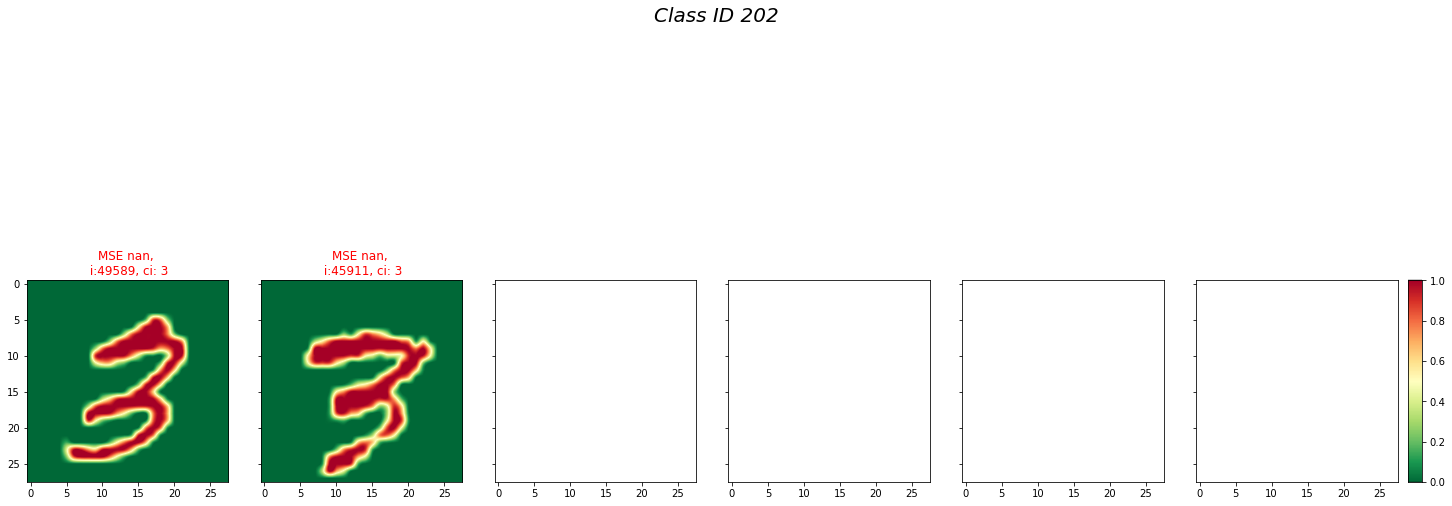

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
total cell: 2/70000 cells
unique cell 2/70000


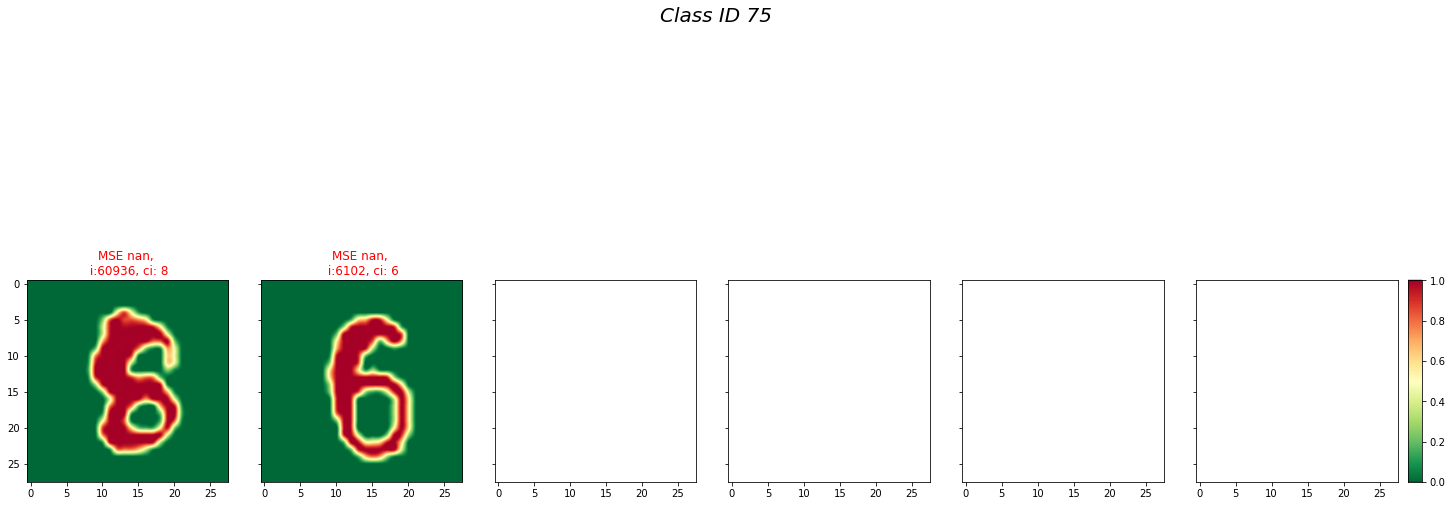

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
total cell: 2/70000 cells
unique cell 2/70000


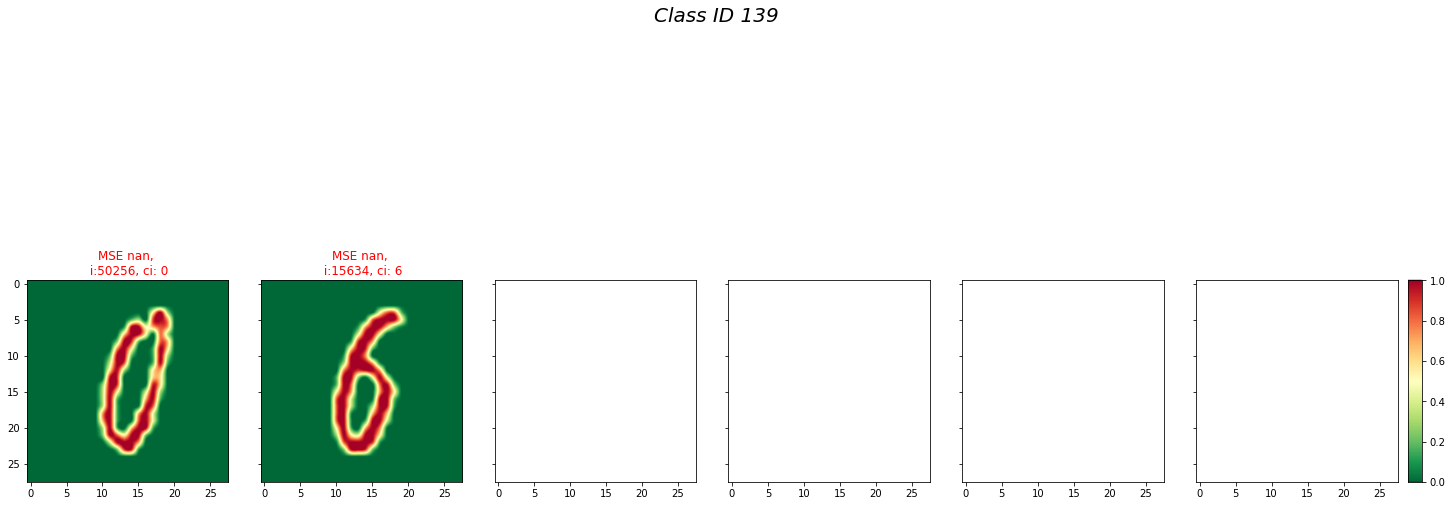

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
total cell: 2/70000 cells
unique cell 1/70000


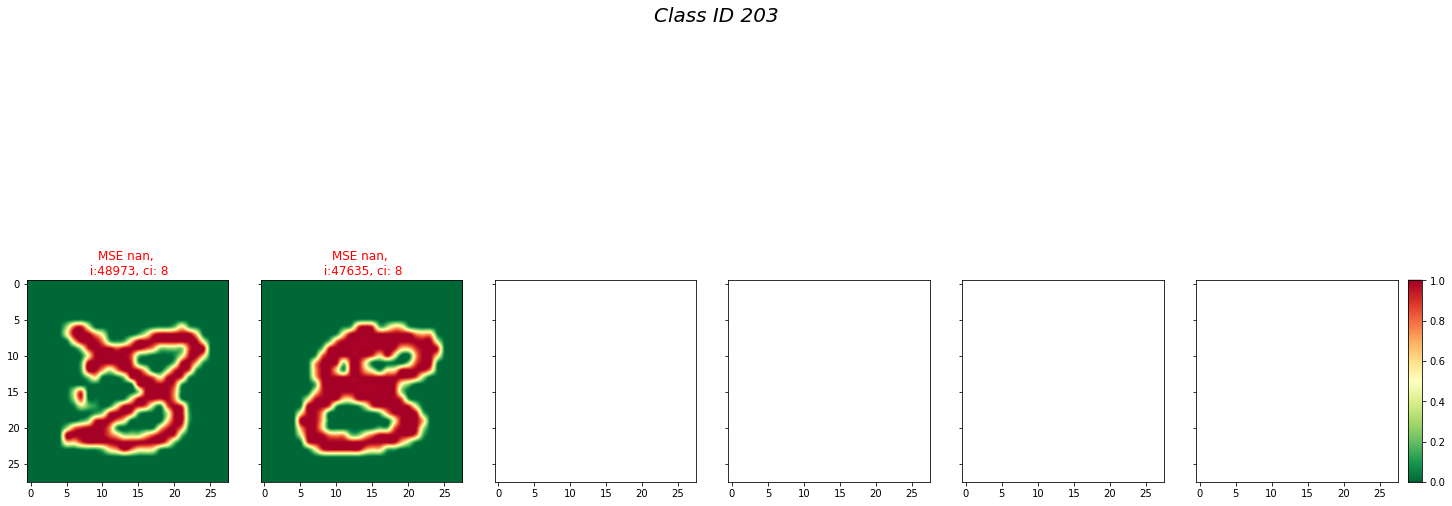

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
total cell: 2/70000 cells
unique cell 1/70000


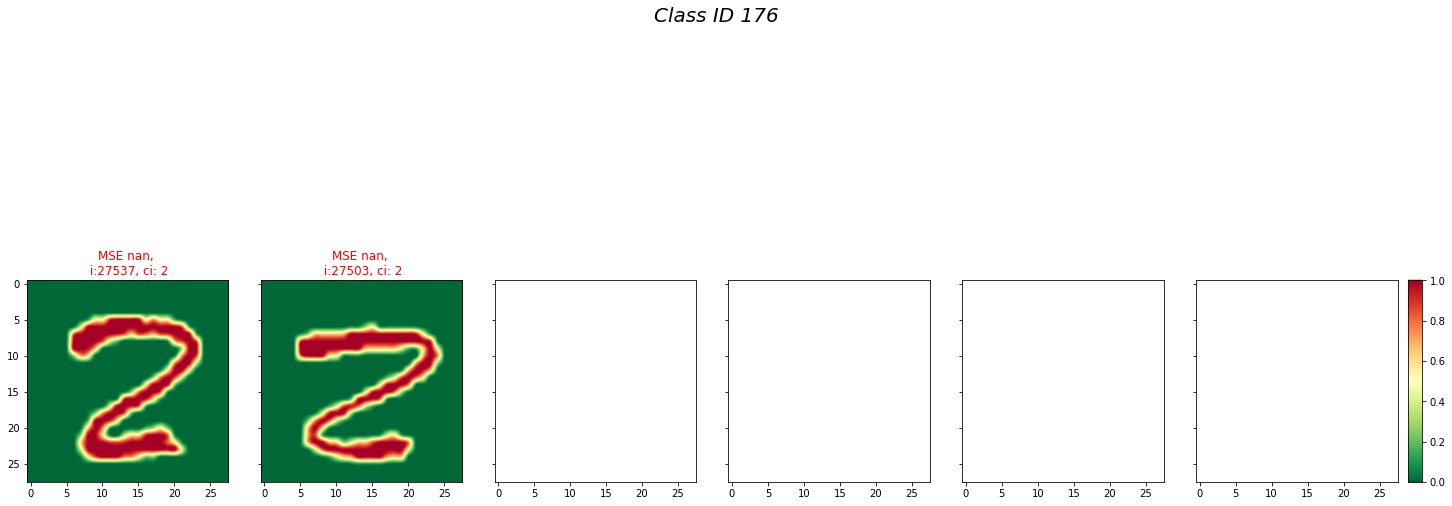

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
total cell: 2/70000 cells
unique cell 2/70000


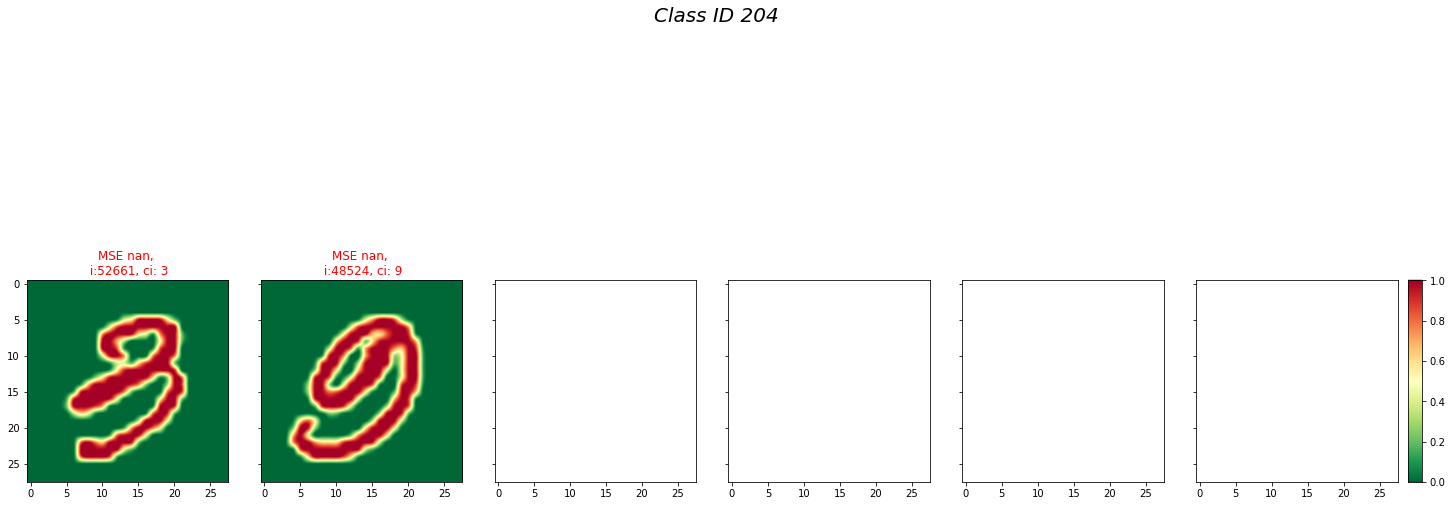

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
total cell: 2/70000 cells
unique cell 2/70000


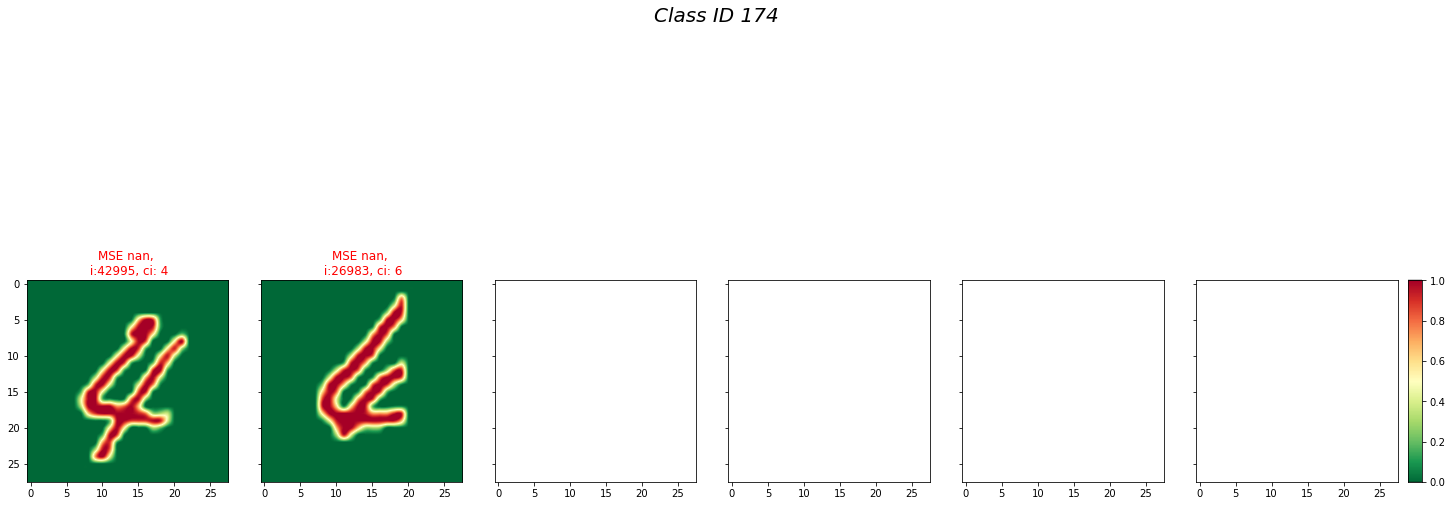

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
total cell: 1/70000 cells
unique cell 1/70000


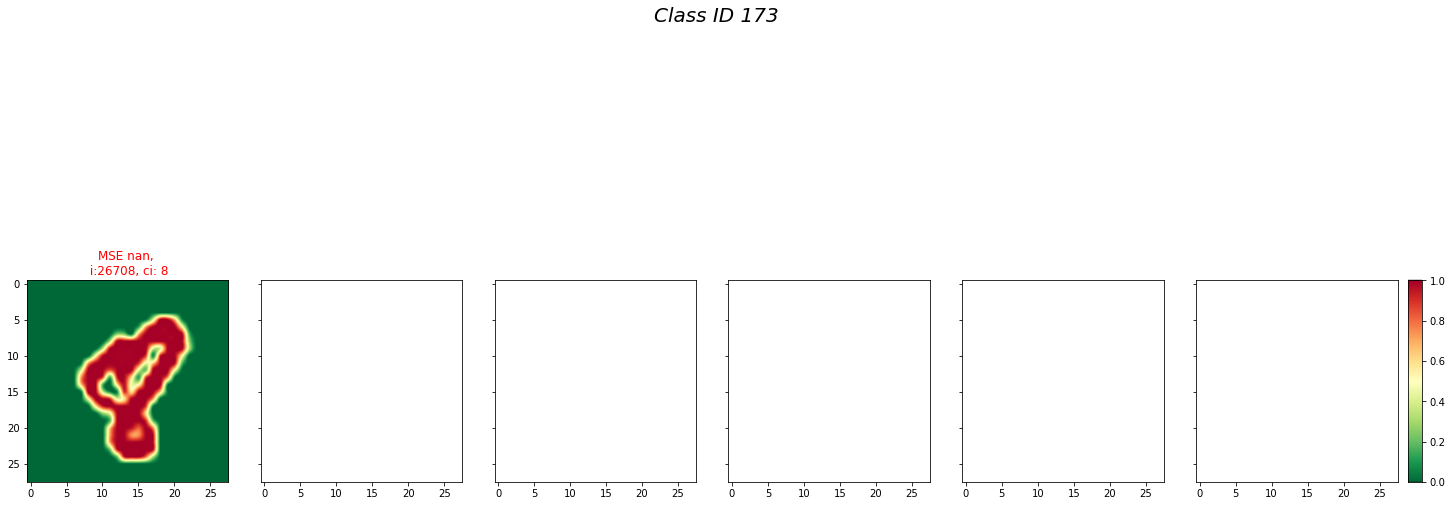

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
total cell: 1/70000 cells
unique cell 1/70000


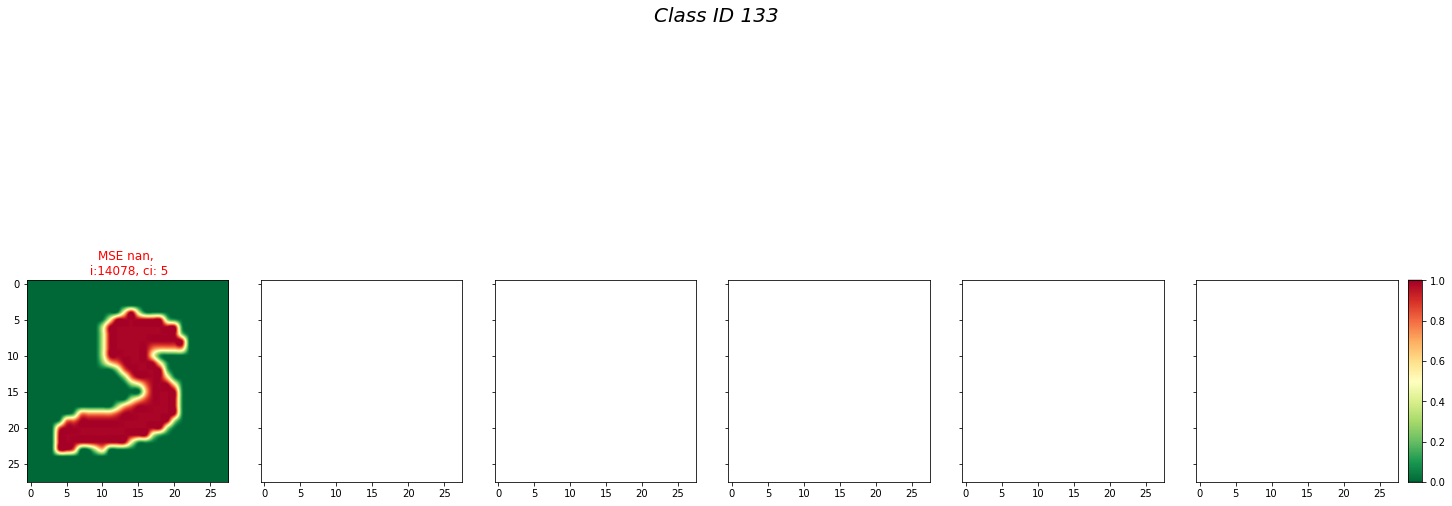

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
total cell: 1/70000 cells
unique cell 1/70000


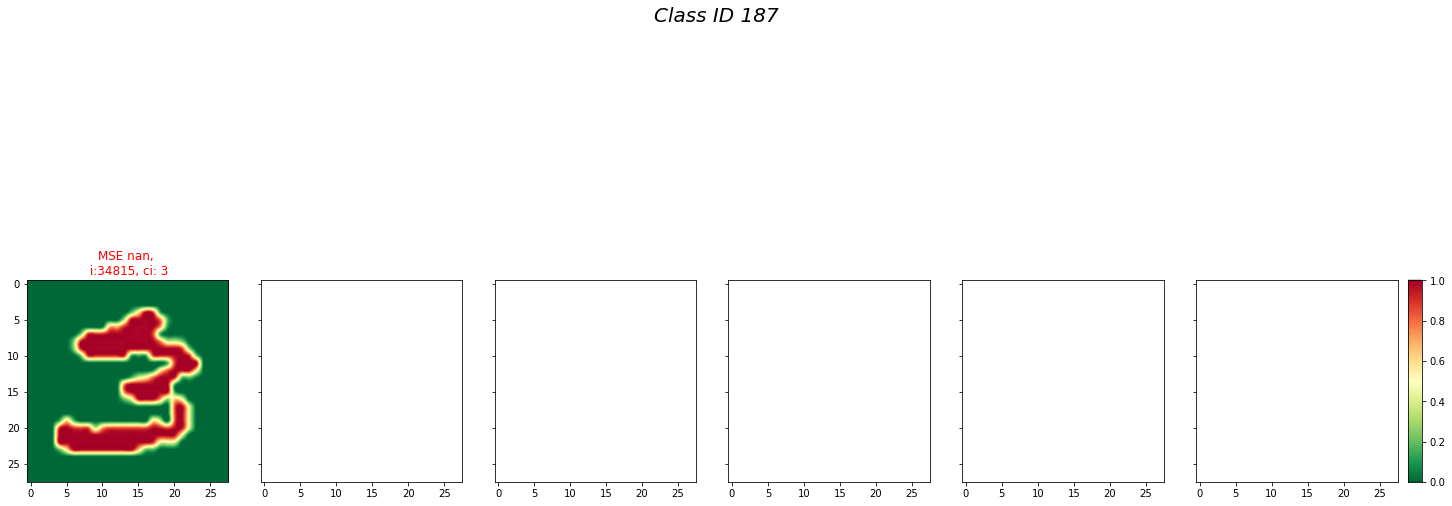

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
total cell: 1/70000 cells
unique cell 1/70000


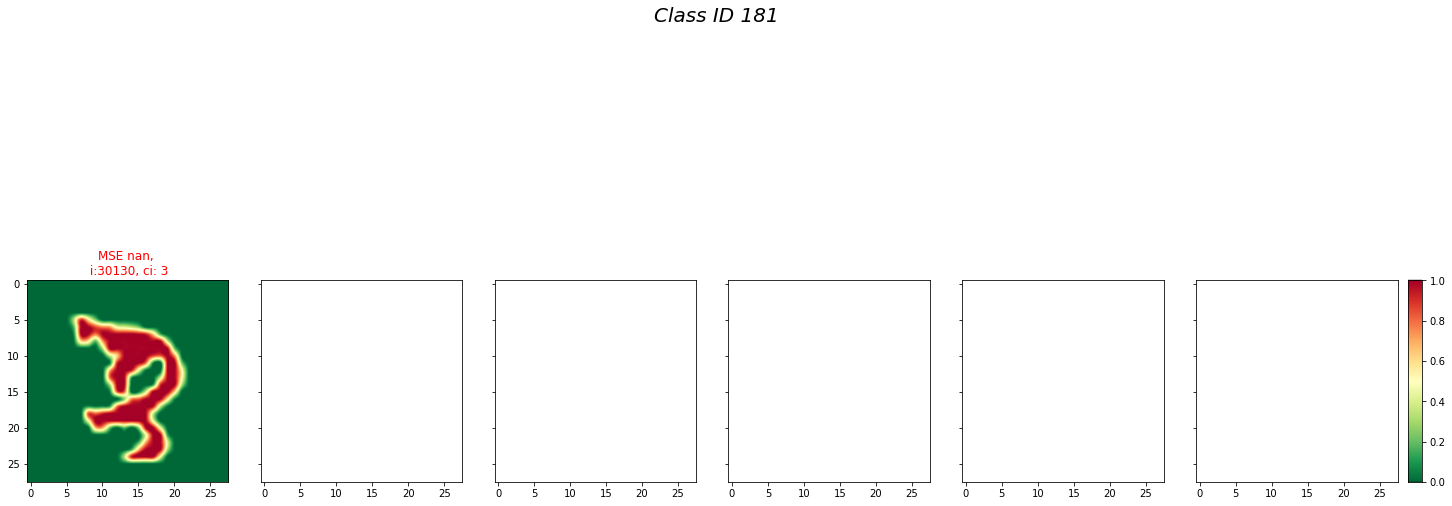

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
total cell: 1/70000 cells
unique cell 1/70000


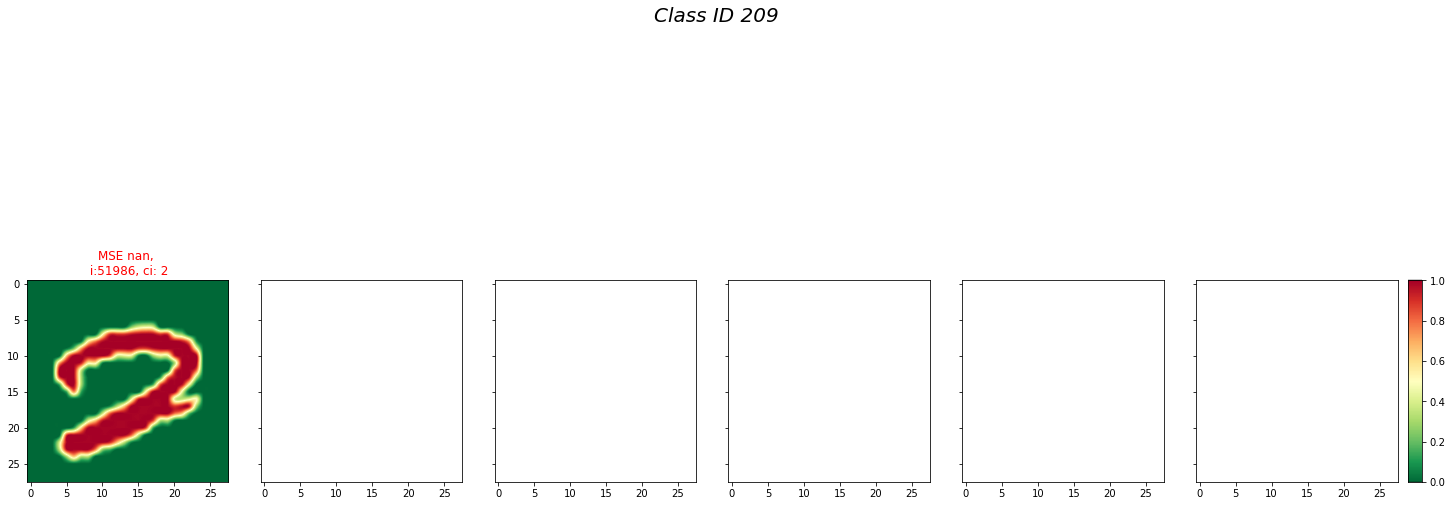

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
total cell: 1/70000 cells
unique cell 1/70000


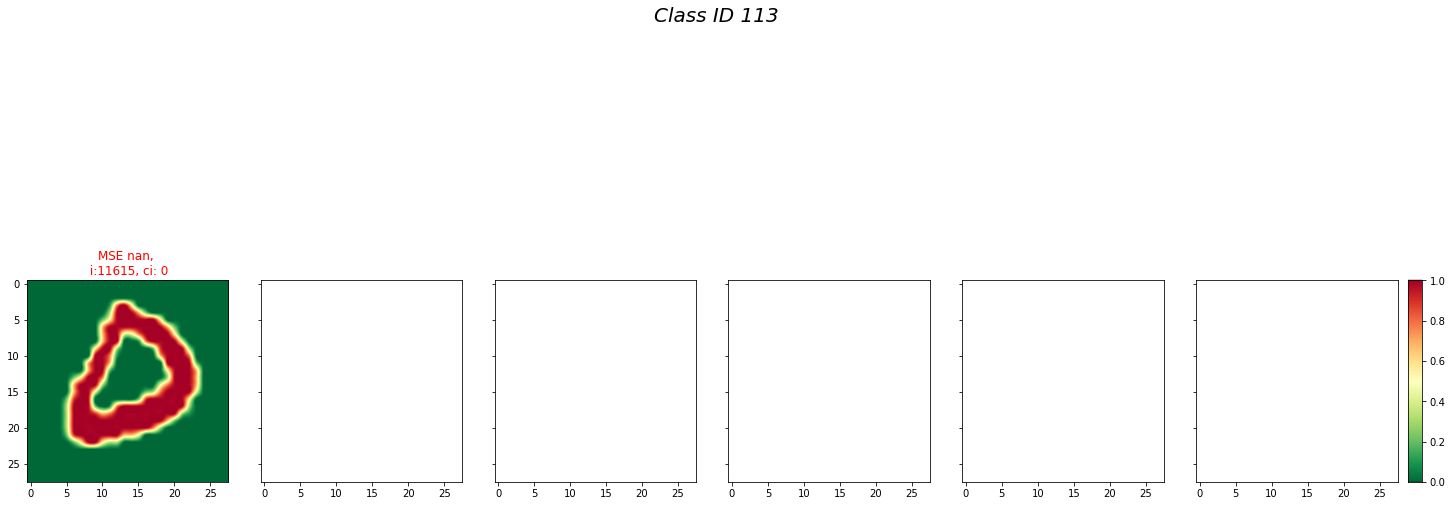

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
total cell: 1/70000 cells
unique cell 1/70000


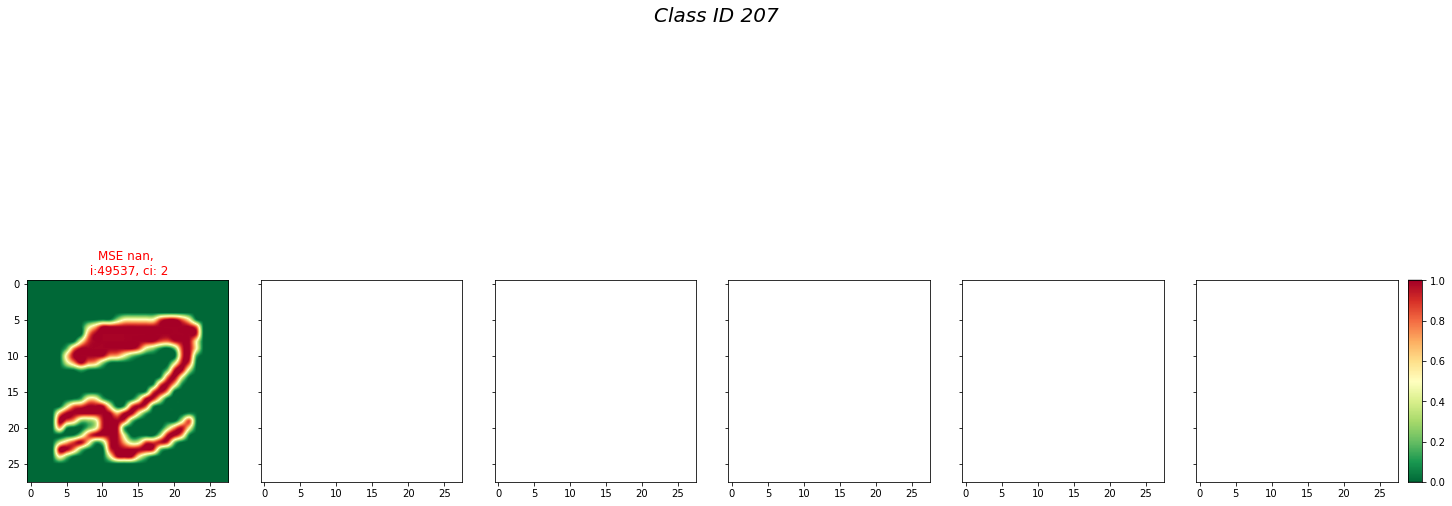

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
total cell: 1/70000 cells
unique cell 1/70000


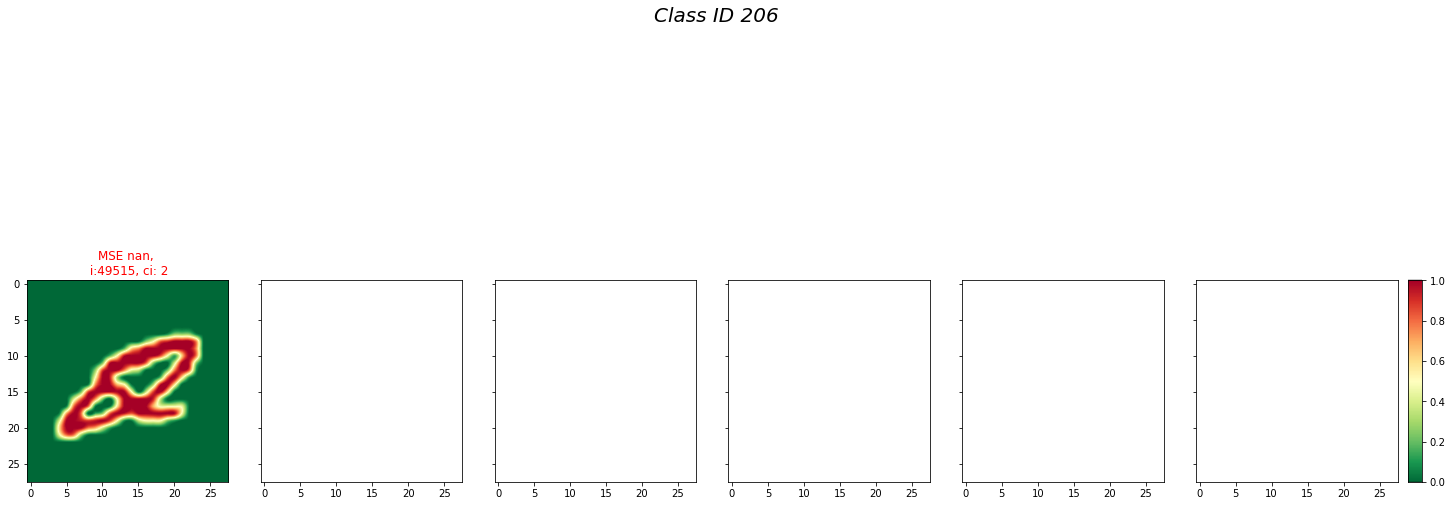

In [162]:
# default parameter values
def_vals = {'x_train' : X_2d, 
            'arr_mse': None, 
            'arr_mse_indx': None, 
            'cell_id': y_gt,
            'label_class': 'my_class', 
            'set_random': True,
            'rowx' : 3, 
            'colx' :6, 
            'img_rows' : 25, 
            'img_cols': 24, 
            'fname': 'plt_heat'}
# update dictionary key value

selcted_clusters = lst_bottom_classes
# selcted_clusters = np.unique(arr_label)
for cluster_id in selcted_clusters:
    class_indx = np.where(y_pred == cluster_id)[0]
    
    def_vals['label_class'] = cluster_id
    def_vals['arr_mse_indx'] = class_indx
    mgcMultiHeat_mse2(**def_vals)